In [17]:
# This is the shared notebook for our project. It contains the code for the data preprocessing, the model training and the model evaluation.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import io

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc, mean_absolute_percentage_error
from sklearn import metrics
import math

In [2]:
# Load the claims data
data = pd.read_csv('claims_data.csv')

# View the first few rows of the dataset
data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [4]:
# Check the data types of each column
data.info()

# Check for missing values
data.isnull().sum()

# Summary statistics for numerical columns
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


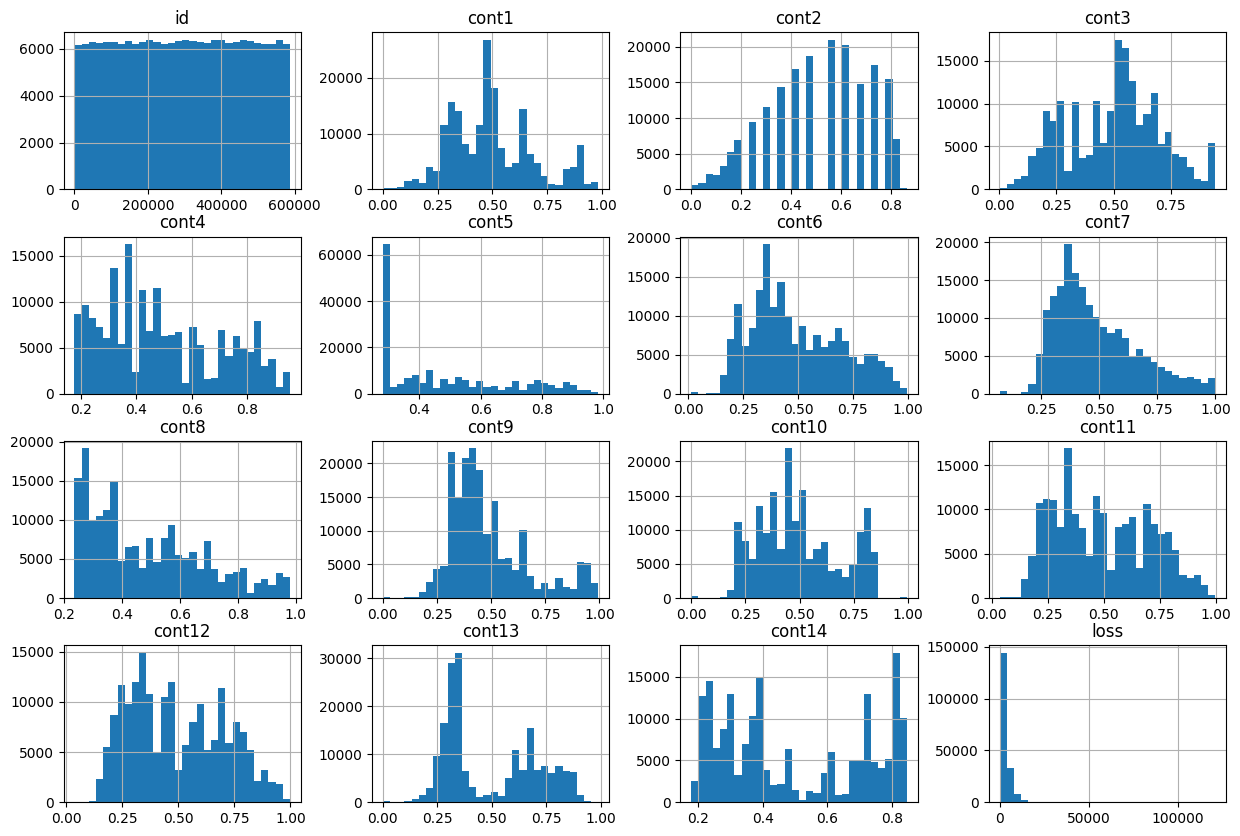

In [5]:
# Visuualizing Data: Understand the distribution of the data
# Plot histograms for numerical columns
data.hist(bins=30, figsize=(15, 10))
plt.show()

In [6]:
# Determine which categorical values cannot be converted to boolean data
categorical = [x for x in data.columns if set(pd.unique(data[x])) != {'A', 'B'} and 'cat' in x]
categorical

['cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 'cat101',
 'cat102',
 'cat103',
 'cat104',
 'cat105',
 'cat106',
 'cat107',
 'cat108',
 'cat109',
 'cat110',
 'cat111',
 'cat112',
 'cat113',
 'cat114',
 'cat115',
 'cat116']

In [7]:
# One-hot encoding function 
def process_cat(data, cat_features):
    for cat in cat_features:
        # One-hot encode the categorical feature
        data_cat = pd.get_dummies(data[cat], prefix=cat)
        
        # Join the new one-hot encoded columns with the original data
        data = data.join(data_cat)
        
        # Drop the original categorical columns
        data.drop(columns=cat, inplace=True)
    
    return data

data = process_cat(data, categorical)

In [8]:
# Convert other categorical data into boolean data
for i in range(1, 73):
    data['cat' + str(i)] = data['cat' + str(i)].replace({'A': True, 'B': False})

data

/var/folders/61/27jd31mj5zgf_mdybbh5gsfm0000gn/T/ipykernel_20997/452813681.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['cat' + str(i)] = data['cat' + str(i)].replace({'A': True, 'B': False})


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat116_P,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_V,cat116_W,cat116_X,cat116_Y
0,1,True,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,5,True,False,True,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,10,False,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,11,True,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
188314,587624,True,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
188315,587630,True,False,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
188316,587632,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# Our label 
y = data['loss']
# Features 
X = data.drop(columns=['id', 'loss'])

In [10]:
# Create training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

In [11]:
# Dimensions of sets 
print(X_train.shape)
print(X_test.shape)

(131822, 1081)
(56496, 1081)


In [12]:
# Random Forest Regressor object  
rf_model = RandomForestRegressor()

In [14]:
# Hyperparameter grid 
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt'],
}

# RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions = param_grid, n_iter=2, cv=3, verbose=2, random_state=123)

# Fit RandomizedSearchCV to training data
rf_random.fit(X_train, y_train)

# Print best hyperparameters
print('The best hyperparameters are: ',rf_random.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=  48.9s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=  49.1s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=  48.2s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  15.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  15.4s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=  15.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The best hyperparameters are:  {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': None}


In [15]:
# Training the Random Forest Regressor model 
rf_model = RandomForestRegressor(n_estimators=50, max_features='sqrt', max_depth= None, random_state=123)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=123)

In [18]:
# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate metrics
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

# Print the metrics
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"R2: {r2}")
print(f"RMSE: {rmse}")

MAE: 1259.3978962829226
MAPE: 0.6701475379617367
MSE: 3951563.987012344
R2: 0.5194754313150489
RMSE: 1987.854116129336
